In [1]:
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

In [2]:
df = pd.read_csv('../csvs/initial_orbital_elements.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr']
Nrows = df.shape[0]
df.head()
print Nrows, len(np.where(df['Stable']==0)[0])
#print np.max(df['beta23'])

14999 9075


In [3]:
df_X= df.ix[:,2:]
df_Y=df['Stable']
df_X.head()
#print np.max(df["beta23"])

,RHill12,RHill23,beta12,beta23,m1,a1,P1,e1,pomega1,inc1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,0.999983,0.005031,3.171041,0.008978,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,1.000000,0.010350,-3.564030,0.001541,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,0.999963,0.051912,0.995149,0.016289,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,1.000000,0.000152,-3.328433,0.003301,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,1.000000,0.001457,1.738448,0.033910,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392


In [4]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions

/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train on the full dataset, then fit on a fixed grid of the two variables wer'e interesteed in, and then use monte carlo simulation to get the values for the rest of the parameters

In [5]:
print df_X.columns.values
model3 = XGBClassifier(seed = 3, learning_rate = 0.01, subsample = 0.9, n_estimators=225, colsample_bytree=0.75, max_depth=9, min_child_weight=4)

['RHill12' 'RHill23' 'beta12' 'beta23' 'm1' 'a1' 'P1' 'e1' 'pomega1' 'inc1'
 'Omega1' 'f1' 'm2' 'a2' 'P2' 'e2' 'pomega2' 'inc2' 'Omega2' 'f2' 'm3' 'a3'
 'P3' 'e3' 'pomega3' 'inc3' 'Omega3' 'f3']


In [6]:
dim = len(list(df_X.columns.values)) -2 # subtract twp because two will remail const
print dim

26


In [7]:
import mcint # monte carlos integration

In [8]:
#use another definition of multivariate guassian
from scipy.stats import multivariate_normal
x= np.linspace(0,5,10)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5)

In [9]:
print y

[ 0.00108914  0.0128652   0.08197202  0.28172908  0.52229358  0.52229358
  0.28172908  0.08197202  0.0128652   0.00108914]


In [10]:
from random import random, uniform , seed
import rebound

def sample_random(seed_val=0):
    a1 = 1. # All distances in units of the innermost semimajor axis (always at 1)
    Mstar = 1. # All masses in units of stellar mass

    logMmin = np.log10(1.e-7) # 1/3 Mars around Sun
    logMmax = np.log10(1.e-4) # 2 Nep around Sun
    logincmin = np.log10(1.e-3)
    logincmax = np.log10(1.e-1) # max mutual inclination of 11.4 degrees. Absolute of 5.7 deg
    seed(seed_val)
    
    
    M1 = 10.**uniform(logMmin, logMmax)
    M2 = 10.**uniform(logMmin, logMmax)
    M3 = 10.**uniform(logMmin, logMmax)
    
    betamin = 1.
    betamax = 30.
    
    hill12 = a1*((M1+M2)/3.)**(1./3.)
    beta1 = uniform(betamin, betamax)
    a2 = a1 + beta1*hill12

    hill23 = a2*((M2+M3)/3.)**(1./3.)
    beta2 = uniform(betamin, betamax)
    a3 = a2 + beta2*hill23

    minhill = min(hill12, hill23)

    ecrit1 = (a2-a1)/a1
    ecrit21 = (a2-a1)/a2
    ecrit23 = (a3-a2)/a2
    ecrit3 = (a3-a2)/a3
    
    logemax1 = np.log10(ecrit1)
    logemax2 = np.log10(min(ecrit21, ecrit23))
    logemax3 = np.log10(ecrit3)

    logemin1 = np.log10(M2/ecrit1**2)
    logemin2 = np.log10(max(M1/ecrit21**2, M3/ecrit23**2))
    logemin3 = np.log10(M2/ecrit3**2)
    
    e1 = min(10.**uniform(logemin1, logemax1), 1.) # make sure ecc < 1
    e2 = min(10.**uniform(logemin2, logemax2), 1.)
    e3 = min(10.**uniform(logemin3, logemax3), 1.)

    i1 = 10.**uniform(logincmin, logincmax)
    i2 = 10.**uniform(logincmin, logincmax)
    i3 = 10.**uniform(logincmin, logincmax)
    
    pomega1=random()*2.*np.pi
    Omega1=random()*2.*np.pi
    
    pomega2=random()*2.*np.pi
    Omega2=random()*2.*np.pi
    
    pomega3=random()*2.*np.pi
    Omega3=random()*2.*np.pi
    
    f1=random()*2.*np.pi # # true anomaly 
    f2=random()*2.*np.pi # # true anomaly 
    f3=random()*2.*np.pi # # true anomaly 

    #return values in same order as they appear in the dataframe
    #['RHill12' 'RHill23' 'beta12' 'beta23' 'm1' 'a1' 'P1' 'e1' 'pomega1' 'inc1'
    #'Omega1' 'f1' 'm2' 'a2' 'P2' 'e2' 'pomega2' 'inc2' 'Omega2' 'f2' 'm3' 'a3'
    #'P3' 'e3' 'pomega3' 'inc3' 'Omega3' 'f3']
    
   

    #use defintion  T = 2pi* (a^3/mu)^0.5, mu = planetmass* G const, but G const here is one?
    G = 4*np.pi**2
    #p1 =2 * np.pi* ((a1**3/M1/G)**0.5) /365.25 #/60. /60. /24. /365.25
    p1 = (a1**3 *4*np.pi**2 /G/(M1+Mstar))**0.5
    p2 = (a2**3 *4*np.pi**2 /G/(M2+Mstar))**0.5
    p3 = (a3**3 *4*np.pi**2 /G/(M3+Mstar))**0.5
        
    #print p1, p2, p3
    
    
    return [hill12, hill23, beta1, beta2, M1, a1, p1, e1, pomega1, i1, Omega1, f1, M2, a2, p2, 
            e2, pomega2, i2, Omega2, f2, M3, a3, p3, e3, pomega3, i3, Omega3, f3]

In [11]:
#not used in final code, just used ot pick values from a gaussain distribution
Nsamples = 100000
cov = np.identity(dim)
rv = multivariate_normal(mean = np.zeros(26), cov= cov) 
data = rv.rvs(Nsamples)
print data.shape
print 50* 2500

(100000, 26)
125000


Note, beta12 and beta34 are the third and fourth samples in the numpy array

In [13]:
grid_size = 50

param1 = np.linspace(1, 30, grid_size) 
param1 = np.tile(param1, grid_size) # 2500 samples, repeat entire list
beta23 = np.linspace(1,30,grid_size)
beta23 = np.repeat(beta23, grid_size)#, 2500 sample, each element repeats, 
#can only repeat at max the length of the list
#beta12 will always repeat, beta32 will only change a value each time beta12 
#completes a cycle

print param1[45:55]
print beta23[95:105]

repetitions = 50

repparam1 = np.repeat(param1, repetitions)# 125 000 samples
repbeta23 = np.repeat(beta23, repetitions)# 125 000 samples

#repeat both 20 times, so for each block of 20,
#beta 12 and beta23 stays the same, as the rest of the other parameters are varied

print beta23.shape, param1.shape
print param1[45:55]
print beta23[45:55]

[ 27.63265306  28.2244898   28.81632653  29.40816327  30.           1.
   1.59183673   2.18367347   2.7755102    3.36734694]
[ 1.59183673  1.59183673  1.59183673  1.59183673  1.59183673  2.18367347
  2.18367347  2.18367347  2.18367347  2.18367347]
(2500,) (2500,)
[ 27.63265306  28.2244898   28.81632653  29.40816327  30.           1.
   1.59183673   2.18367347   2.7755102    3.36734694]
[ 1.          1.          1.          1.          1.          1.59183673
  1.59183673  1.59183673  1.59183673  1.59183673]


In [17]:
planets_data = np.zeros((repparam1.shape[0], 28)) #= sample_random()
print planets_data.shape[0]
for i in range(planets_data.shape[0]):
    planets_data[i, :] = sample_random(i+3452367)
    #print planets_data[i, :]

125000


In [18]:
print planets_data.shape, repparam1.shape, repbeta23.shape
print planets_data[:3,:]
print repparam1[:3]
print repbeta23[:3]

(125000, 28) (125000,) (125000,)
[[  1.69977666e-02   2.05204094e-02   1.29003018e+01   1.64087675e+01
    7.12373830e-07   1.00000000e+00   9.99999644e-01   1.52549991e-03
    1.52021381e+00   1.94034078e-03   3.71440776e+00   2.91743437e+00
    1.40208178e-05   1.21927632e+00   1.34632579e+00   1.48296820e-03
    4.10100488e+00   1.69934776e-02   9.98793560e-01   2.15434810e-01
    2.80396030e-07   1.55599095e+00   1.94093297e+00   1.16788907e-02
    5.91757773e+00   3.09167472e-03   3.46326917e+00   4.83929686e+00]
 [  1.54820301e-02   2.14569984e-02   2.12944682e+01   1.13497210e+00
    8.00188540e-06   1.00000000e+00   9.99995999e-01   9.18014793e-02
    2.01529817e+00   1.80773911e-02   4.60705284e+00   1.70543305e+00
    3.13092913e-06   1.32968160e+00   1.53327766e+00   2.73488954e-02
    4.38507901e+00   2.50221850e-03   2.24329855e+00   6.23114884e+00
    9.47529969e-06   1.35403469e+00   1.57558787e+00   1.19479457e-02
    5.08000113e+00   6.50783526e-02   5.85194376e+00   2

In [19]:
#data_predictions = np.column_stack((data[:,:2], beta12, beta23, data[:,2:]), )
data_predictions = np.column_stack((planets_data[:,:2], repparam1, repbeta23, planets_data[:,4:]), )
data_predictions.shape

(125000, 28)

In [20]:
print data_predictions[:3,:]

[[  1.69977666e-02   2.05204094e-02   1.00000000e+00   1.00000000e+00
    7.12373830e-07   1.00000000e+00   9.99999644e-01   1.52549991e-03
    1.52021381e+00   1.94034078e-03   3.71440776e+00   2.91743437e+00
    1.40208178e-05   1.21927632e+00   1.34632579e+00   1.48296820e-03
    4.10100488e+00   1.69934776e-02   9.98793560e-01   2.15434810e-01
    2.80396030e-07   1.55599095e+00   1.94093297e+00   1.16788907e-02
    5.91757773e+00   3.09167472e-03   3.46326917e+00   4.83929686e+00]
 [  1.54820301e-02   2.14569984e-02   1.00000000e+00   1.00000000e+00
    8.00188540e-06   1.00000000e+00   9.99995999e-01   9.18014793e-02
    2.01529817e+00   1.80773911e-02   4.60705284e+00   1.70543305e+00
    3.13092913e-06   1.32968160e+00   1.53327766e+00   2.73488954e-02
    4.38507901e+00   2.50221850e-03   2.24329855e+00   6.23114884e+00
    9.47529969e-06   1.35403469e+00   1.57558787e+00   1.19479457e-02
    5.08000113e+00   6.50783526e-02   5.85194376e+00   2.39665907e+00]
 [  1.37536600e-02

In [21]:
model1 = XGBClassifier(n_estimators=225, learning_rate=1, max_depth = 3)
x =df_X.as_matrix()
y = df_Y.as_matrix()
model1.fit(x, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=225, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [257]:
0%20 

0

In [23]:
mean_preds = np.zeros(param1.shape[0]) #want average prediction of each beta12 and beta 23 value
preds = np.zeros(planets_data.shape) #total number or predictions
#do all the testings
# not correct, each pred is only predicting one value, although its a much finer grid
count = 0;

#try a more effiicent solution

preds = model1.predict_proba(data_predictions)[:,1]

In [24]:
print preds.shape, mean_preds.shape, preds[5:10]
count = 0
for i, val in enumerate(preds):
    if i % repetitions ==(repetitions-1):
        #print i
        mean_preds[count]=np.mean(preds[i-19:i])
        count +=1
print mean_preds[:4]
print preds[:4]

(125000,) (2500,) [  5.27701277e-12   9.16229332e-13   9.47575390e-05   4.64773308e-07
   3.39691643e-11]
[  1.91859158e-06   2.51744405e-05   3.25085508e-04   3.16083222e-03]
[  1.32898015e-06   5.75230662e-12   7.33695131e-08   4.56306440e-14]


[ 0.8019473   0.74665678  0.6283136 ]


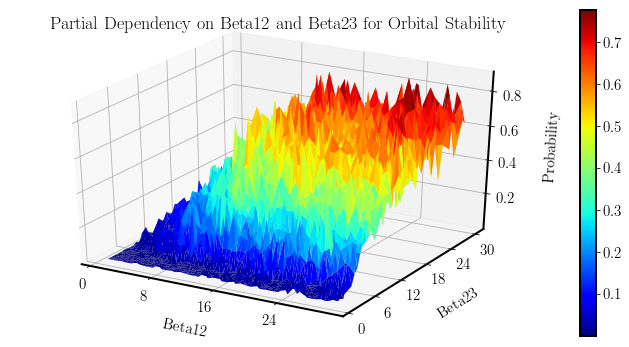

In [28]:
from matplotlib import rc, cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

rc('text',usetex=True)
rc('font',family='serif')
rc('font',serif='cm')
rc('font',size=15,weight='black',stretch='extra-expanded',style='oblique')
rc('axes',linewidth=2)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111, projection='3d')

#print beta12.shape, beta23.shape, mean_preds.shape
print mean_preds[-3:]

surf = ax.plot_trisurf(param1, beta23, mean_preds, cmap=cm.jet, linewidth=0)
#surf = ax.scatter(beta12, beta23, mean_preds, cmap=cm.jet, linewidth=0)

fig.colorbar(surf)
ax.tick_params(axis='both', which='major', pad=3)
#ax.rcParams['ytick.major.pad']='8'

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel('Beta12', labelpad=15)
ax.set_ylabel('Beta23', labelpad=15)
ax.set_zlabel('Probability', labelpad=15)
ax.set_title('Partial Dependency on Beta12 and Beta23 for Orbital Stability')
#ax.plot_surface(x_list, y_list, varyin_pred_mean)
#ax.ad
plt.show()

Lots of noise in the graph

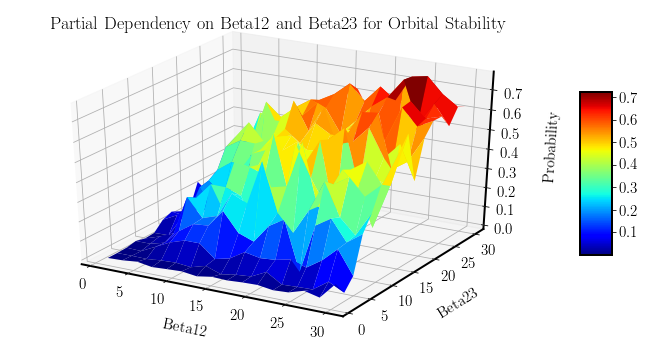

In [49]:
from scipy.interpolate import griddata

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111, projection='3d')

xi = np.linspace(param1.min(), param1.max(),(len(mean_preds)/150))
yi = np.linspace(beta23.min(),beta23.max(),(len(mean_preds)/150))


zi = griddata((param1, beta23), mean_preds, (xi[None,:], yi[:,None]), method='cubic')


xig, yig = np.meshgrid(xi, yi)



surf = ax.plot_surface(xig, yig, zi, cmap=cm.jet)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Beta12', labelpad=15)
ax.set_ylabel('Beta23', labelpad=15)
ax.set_zlabel('Probability', labelpad=15)
ax.set_title('Partial Dependency on Beta12 and Beta23 for Orbital Stability')


In [50]:
mean_preds_grid = mean_preds.reshape(grid_size, grid_size)

Try using a gaussian filter on the data to further reduce the noise in the data

In [52]:
from scipy import ndimage
img_gauss = ndimage.filters.gaussian_filter(mean_preds_grid, 2.5, mode = 'reflect')

In [53]:
mean_preds_linear = img_gauss.reshape(1, grid_size**2)
mean_preds_linear = mean_preds_linear.flatten()
print mean_preds_linear.shape

(2500,)


In [56]:
print df_X.columns[1]

RHill23


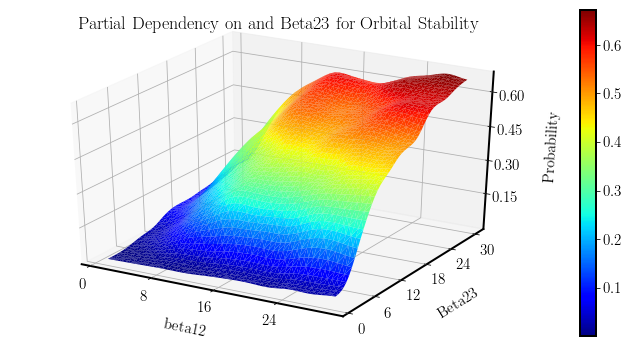

In [59]:
rc('text',usetex=True)
rc('font',family='serif')
rc('font',serif='cm')
rc('font',size=15,weight='black',stretch='extra-expanded',style='oblique')
rc('axes',linewidth=2)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(param1, beta23, mean_preds_linear, cmap=cm.jet, linewidth=0)

fig.colorbar(surf)
ax.tick_params(axis='both', which='major', pad=3)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel(df_X.columns[2], labelpad=15)
ax.set_ylabel('Beta23', labelpad=15)
ax.set_zlabel('Probability', labelpad=15)
ax.set_title('Partial Dependency on  and Beta23 for Orbital Stability')
#ax.plot_surface(x_list, y_list, varyin_pred_mean)
#ax.ad
plt.show()